In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import math

In [3]:
import torch
from torchvision import transforms, datasets

train_data_transform = transforms.Compose([
        
#         transforms.Lambda(lbp_transform),
#         transforms.Lambda(combine_lbp_hog),
#         transforms.ToPILImage(),
        # transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=12),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

test_data_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

train_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/cleaned_data/fer2013-clean/Training', transform=train_data_transform)
val_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/cleaned_data/fer2013-clean/PublicTest', transform=test_data_transform)
test_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/cleaned_data/fer2013-clean/PrivateTest/', transform=test_data_transform)

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)

In [4]:
class Sublayer(nn.Module):
    def __init__(self, in_depth, emb_dim):
        super(Sublayer, self).__init__()
        
        self.fc1_a = nn.Linear(in_depth, in_depth)
        self.bn1_a = nn.BatchNorm1d(in_depth)
        self.fc1_b = nn.Linear(in_depth, in_depth)
        self.bn1_b = nn.BatchNorm1d(in_depth)
        self.fc1_c = nn.Linear(in_depth, in_depth)
        self.bn1_c = nn.BatchNorm1d(in_depth)
        
        self.fc_out = nn.Linear(3*in_depth, in_depth)
        self.bn_out = nn.BatchNorm1d(in_depth)
        
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        identity = x
        
        x = nn.Flatten(-2)(x).permute(0,2,1)
        
#         print('x: ', x.size())
        a = self.fc1_a(x)
        a = a.permute(0,2,1)
        a = self.relu(self.bn1_a(a))
        
        b = self.fc1_b(x)
        b = b.permute(0,2,1)
        b = self.relu(self.bn1_b(b))
        
        c = self.fc1_c(x)
        c = c.permute(0,2,1)
        c = self.relu(self.bn1_c(c))
        
        
        concat = torch.cat([a,b,c], dim=1)
        concat = concat.permute(0,2,1)
        
        concat = self.fc_out(concat)
        concat = concat.permute(0,2,1)
        concat = self.bn_out(concat)

        concat = concat.view(identity.size())
        
        x_out = identity + concat
        
        return x_out

In [4]:
class Model(nn.Module):
    def __init__(self, **kwargs):
        super(Model, self).__init__()
        
        self.device = kwargs['device']
        self.b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(True), nn.BatchNorm2d(64),
                                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(True), nn.BatchNorm2d(64)).to(self.device)
        
        self.b2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(True), nn.BatchNorm2d(128),
                                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(True), nn.BatchNorm2d(128)).to(self.device)
        
        self.b3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), nn.ReLU(True), nn.BatchNorm2d(256),
                                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), nn.ReLU(True), nn.BatchNorm2d(256),
                                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), nn.ReLU(True), nn.BatchNorm2d(256)).to(self.device)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.sub1 = Sublayer(64, 64).to(self.device)
        self.sub2 = Sublayer(128, 128).to(self.device)
        self.sub3 = Sublayer(256, 256).to(self.device)
        
        self.classifier = nn.Sequential(nn.Linear(256, 256), nn.BatchNorm1d(256),
                                        nn.Linear(256, 7), nn.BatchNorm1d(7)).to(self.device)
        
    def forward(self, x):
        x = self.b1(x)
        x = self.sub1(x)
        x = self.pool(x)
        
        x = self.b2(x)
        x = self.sub2(x)
        x = self.pool(x)
        
        x = self.b3(x)
        x = self.sub3(x)
        x = self.pool(x)
        
        x = nn.Flatten()(nn.AvgPool2d(kernel_size = x.size(2))(x))
        
        x = self.classifier(x)
        
        return x
        

In [6]:
device = torch.device('cuda')
model = Model(device=device)
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
# reduce_factor = 5
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)


In [7]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/'
model_name = 'resnet50'
# model_path = os.path.join(model_folder, model_name + '.pt')
model_path = None

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(300):  # loop over the dataset multiple times
    
#     if (epoch % 60) == 0 and epoch != 0:
#         learning_rate /= reduce_factor
#         print('Decrese learning rate to: ', learning_rate)
#         optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        
        if not model_path is None:
            torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

Epoch:  1
- Avg.loss: 1.917  | Avg.acc: 0.245
- Avg. val_loss: 1.815  | Avg. val_acc: 0.312
* Update optimal model
Epoch:  2
- Avg.loss: 1.796  | Avg.acc: 0.321
- Avg. val_loss: 1.768  | Avg. val_acc: 0.330
* Update optimal model
Epoch:  3
- Avg.loss: 1.720  | Avg.acc: 0.361
- Avg. val_loss: 1.691  | Avg. val_acc: 0.369
* Update optimal model
Epoch:  4
- Avg.loss: 1.657  | Avg.acc: 0.391
- Avg. val_loss: 1.646  | Avg. val_acc: 0.403
* Update optimal model
Epoch:  5
- Avg.loss: 1.600  | Avg.acc: 0.417
- Avg. val_loss: 1.603  | Avg. val_acc: 0.420
* Update optimal model
Epoch:  6
- Avg.loss: 1.558  | Avg.acc: 0.435
- Avg. val_loss: 1.559  | Avg. val_acc: 0.444
* Update optimal model
Epoch:  7
- Avg.loss: 1.511  | Avg.acc: 0.454
- Avg. val_loss: 1.567  | Avg. val_acc: 0.422
Epoch:  8
- Avg.loss: 1.479  | Avg.acc: 0.471
- Avg. val_loss: 1.531  | Avg. val_acc: 0.457
* Update optimal model
Epoch:  9
- Avg.loss: 1.451  | Avg.acc: 0.481
- Avg. val_loss: 1.510  | Avg. val_acc: 0.447
Epoch:  10


KeyboardInterrupt: 

In [8]:
device = torch.device('cuda')
criterion = nn.CrossEntropyLoss()

learning_rate = 0.0001
# reduce_factor = 5
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)


In [9]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/'
model_name = 'resnet50'
# model_path = os.path.join(model_folder, model_name + '.pt')
model_path = None

# best_acc = 0.0
# curloss = 0.0
hist2 = []

for epoch in range(75, 100):  # loop over the dataset multiple times
    
#     if (epoch % 60) == 0 and epoch != 0:
#         learning_rate /= reduce_factor
#         print('Decrese learning rate to: ', learning_rate)
#         optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist2.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        
        if not model_path is None:
            torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

Epoch:  76
- Avg.loss: 0.679  | Avg.acc: 0.798
- Avg. val_loss: 1.264  | Avg. val_acc: 0.560
Epoch:  77
- Avg.loss: 0.675  | Avg.acc: 0.800
- Avg. val_loss: 1.178  | Avg. val_acc: 0.594
* Update optimal model
Epoch:  78
- Avg.loss: 0.668  | Avg.acc: 0.806
- Avg. val_loss: 1.209  | Avg. val_acc: 0.573
Epoch:  79
- Avg.loss: 0.664  | Avg.acc: 0.805
- Avg. val_loss: 1.165  | Avg. val_acc: 0.592
Epoch:  80
- Avg.loss: 0.661  | Avg.acc: 0.811
- Avg. val_loss: 1.174  | Avg. val_acc: 0.593
Epoch:  81
- Avg.loss: 0.659  | Avg.acc: 0.810
- Avg. val_loss: 1.198  | Avg. val_acc: 0.572
Epoch:  82
- Avg.loss: 0.660  | Avg.acc: 0.808
- Avg. val_loss: 1.240  | Avg. val_acc: 0.551
Epoch:  83
- Avg.loss: 0.660  | Avg.acc: 0.806
- Avg. val_loss: 1.189  | Avg. val_acc: 0.572
Epoch:  84
- Avg.loss: 0.657  | Avg.acc: 0.812
- Avg. val_loss: 1.216  | Avg. val_acc: 0.555
Epoch:  85
- Avg.loss: 0.652  | Avg.acc: 0.812
- Avg. val_loss: 1.191  | Avg. val_acc: 0.576
Epoch:  86
- Avg.loss: 0.650  | Avg.acc: 0.814


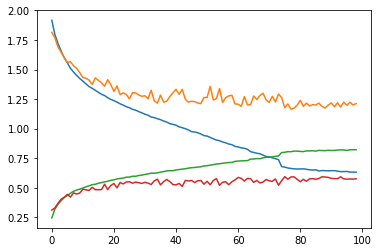

In [10]:
plt.plot(hist+hist2)

In [13]:
import pickle

pickle.dump(hist+hist2, open('./temp_sublayer_hist.hdf5', 'wb'))

## Normal

In [5]:
class Model(nn.Module):
    def __init__(self, **kwargs):
        super(Model, self).__init__()
        
        self.device = kwargs['device']
        self.b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(True), nn.BatchNorm2d(64),
                                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(True), nn.BatchNorm2d(64)).to(self.device)
        
        self.b2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(True), nn.BatchNorm2d(128),
                                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(True), nn.BatchNorm2d(128)).to(self.device)
        
        self.b3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), nn.ReLU(True), nn.BatchNorm2d(256),
                                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), nn.ReLU(True), nn.BatchNorm2d(256),
                                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), nn.ReLU(True), nn.BatchNorm2d(256)).to(self.device)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
#         self.sub1 = Sublayer(64, 64).to(self.device)
#         self.sub2 = Sublayer(128, 128).to(self.device)
#         self.sub3 = Sublayer(256, 256).to(self.device)
        
        self.classifier = nn.Sequential(nn.Linear(256, 256), nn.BatchNorm1d(256),
                                        nn.Linear(256, 7), nn.BatchNorm1d(7)).to(self.device)
        
    def forward(self, x):
        x = self.b1(x)
        x = self.pool(x)
        
        x = self.b2(x)
        x = self.pool(x)
        
        x = self.b3(x)
        x = self.pool(x)
        
        x = nn.Flatten()(nn.AvgPool2d(kernel_size = x.size(2))(x))
        
        x = self.classifier(x)
        
        return x
        

In [6]:
device = torch.device('cuda')
model = Model(device=device)
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
# reduce_factor = 5
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)


In [7]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/'
model_name = 'resnet50'
# model_path = os.path.join(model_folder, model_name + '.pt')
model_path = None

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(75):  # loop over the dataset multiple times
    
#     if (epoch % 60) == 0 and epoch != 0:
#         learning_rate /= reduce_factor
#         print('Decrese learning rate to: ', learning_rate)
#         optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        
        if not model_path is None:
            torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

Epoch:  1
- Avg.loss: 1.896  | Avg.acc: 0.247
- Avg. val_loss: 1.855  | Avg. val_acc: 0.278
* Update optimal model
Epoch:  2
- Avg.loss: 1.774  | Avg.acc: 0.331
- Avg. val_loss: 1.762  | Avg. val_acc: 0.324
* Update optimal model
Epoch:  3
- Avg.loss: 1.693  | Avg.acc: 0.373
- Avg. val_loss: 1.681  | Avg. val_acc: 0.376
* Update optimal model
Epoch:  4
- Avg.loss: 1.635  | Avg.acc: 0.399
- Avg. val_loss: 1.633  | Avg. val_acc: 0.380
* Update optimal model
Epoch:  5
- Avg.loss: 1.583  | Avg.acc: 0.423
- Avg. val_loss: 1.624  | Avg. val_acc: 0.398
* Update optimal model
Epoch:  6
- Avg.loss: 1.544  | Avg.acc: 0.437
- Avg. val_loss: 1.550  | Avg. val_acc: 0.434
* Update optimal model
Epoch:  7
- Avg.loss: 1.511  | Avg.acc: 0.452
- Avg. val_loss: 1.557  | Avg. val_acc: 0.430
Epoch:  8
- Avg.loss: 1.479  | Avg.acc: 0.469
- Avg. val_loss: 1.577  | Avg. val_acc: 0.421
Epoch:  9
- Avg.loss: 1.451  | Avg.acc: 0.476
- Avg. val_loss: 1.536  | Avg. val_acc: 0.431
Epoch:  10
- Avg.loss: 1.426  | Av

In [9]:
device = torch.device('cuda')
criterion = nn.CrossEntropyLoss()

learning_rate = 0.0001
# reduce_factor = 5
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)


In [10]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/'
model_name = 'resnet50'
# model_path = os.path.join(model_folder, model_name + '.pt')
model_path = None

# best_acc = 0.0
# curloss = 0.0
hist2 = []

for epoch in range(75, 100):  # loop over the dataset multiple times
    
#     if (epoch % 60) == 0 and epoch != 0:
#         learning_rate /= reduce_factor
#         print('Decrese learning rate to: ', learning_rate)
#         optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist2.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        
        if not model_path is None:
            torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

Epoch:  76
- Avg.loss: 0.739  | Avg.acc: 0.772
- Avg. val_loss: 1.139  | Avg. val_acc: 0.606
* Update optimal model
Epoch:  77
- Avg.loss: 0.730  | Avg.acc: 0.775
- Avg. val_loss: 1.218  | Avg. val_acc: 0.569
Epoch:  78
- Avg.loss: 0.731  | Avg.acc: 0.777
- Avg. val_loss: 1.187  | Avg. val_acc: 0.584
Epoch:  79
- Avg.loss: 0.726  | Avg.acc: 0.778
- Avg. val_loss: 1.176  | Avg. val_acc: 0.585
Epoch:  80
- Avg.loss: 0.726  | Avg.acc: 0.777
- Avg. val_loss: 1.147  | Avg. val_acc: 0.606
* Update optimal model
Epoch:  81
- Avg.loss: 0.722  | Avg.acc: 0.780
- Avg. val_loss: 1.164  | Avg. val_acc: 0.586
Epoch:  82
- Avg.loss: 0.718  | Avg.acc: 0.781
- Avg. val_loss: 1.156  | Avg. val_acc: 0.603
Epoch:  83
- Avg.loss: 0.716  | Avg.acc: 0.783
- Avg. val_loss: 1.163  | Avg. val_acc: 0.608
* Update optimal model
Epoch:  84
- Avg.loss: 0.719  | Avg.acc: 0.780
- Avg. val_loss: 1.158  | Avg. val_acc: 0.587
Epoch:  85
- Avg.loss: 0.716  | Avg.acc: 0.785
- Avg. val_loss: 1.182  | Avg. val_acc: 0.589
E

In [13]:
import pickle
pickle.dump(hist+hist2, open('./temp_normal_hist.hdf5', 'wb'))

In [15]:
sub_hist = pickle.load(open('./temp_sublayer_hist.hdf5', 'rb'))
norm_hist = pickle.load(open('./temp_normal_hist.hdf5', 'rb'))



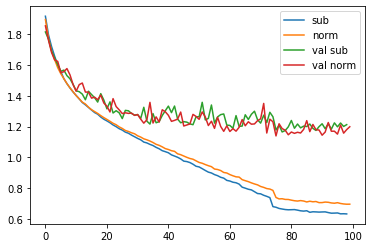

In [25]:
plt.plot([k[0] for k in sub_hist], label='sub')
plt.plot([k[0] for k in norm_hist], label='norm')
plt.plot([k[1] for k in sub_hist], label='val sub')
plt.plot([k[1] for k in norm_hist], label='val norm')
plt.legend()

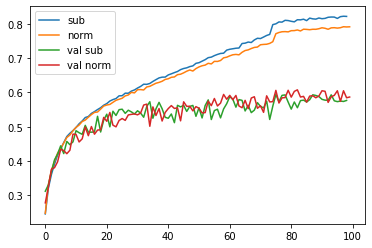

In [26]:
plt.plot([k[2] for k in sub_hist], label='sub')
plt.plot([k[2] for k in norm_hist], label='norm')
plt.plot([k[3] for k in sub_hist], label='val sub')
plt.plot([k[3] for k in norm_hist], label='val norm')
plt.legend()

In [21]:
sub_hist



[[1.9171652139297553,
  1.8149638710350826,
  0.24547061018113578,
  0.31169181034482757],
 [1.7959766015410423,
  1.7680908852610095,
  0.3206496466217296,
  0.3302801724137931],
 [1.7198897946093763,
  1.6909997298799713,
  0.36088634681488785,
  0.36907327586206895],
 [1.6572757379284926,
  1.6463884320752373,
  0.391124907082745,
  0.4032866379310345],
 [1.6000193511801106,
  1.6025445790126407,
  0.41743164070482763,
  0.4202586206896552],
 [1.5579129265887397,
  1.5594790886188377,
  0.43452148445482763,
  0.4442349137931034],
 [1.5111477699662959,
  1.5668752892264004,
  0.45382254464285715,
  0.42160560344827586],
 [1.4790236614644527, 1.5311937989859745, 0.471435546875, 0.45716594827586204],
 [1.450785856693983,
  1.5103227681127087,
  0.4808965775051287,
  0.4474676724137931],
 [1.4248505953167165,
  1.474491703099218,
  0.48868815121906145,
  0.4558189655172414],
 [1.4022567352013928,
  1.432411935822717,
  0.4979631697226848,
  0.48841594827586204],
 [1.3795348953987872,
  